In [1]:
import torch
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import regularization as R
from modules import NMU, NAU, LeibnizModule
from samplers import *
from datasets import MatrixDeterminantDataset, BatchDataLoader

torch.cuda.set_device(2)

In [3]:
def train_until_convergence(
    model,
    train_loader,
    dataset_valid_interpolation_data,
    dataset_test_extrapolation_data,
    regualizer_scaling_start=5000,
    max_iter=20000,
    alpha_scale=1.001,
    alpha_start=0.05,
    check_period=250,
    lr=2e-3,
    verbose=False
):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.MSELoss()
    
    def test_model(data):
        with torch.no_grad():
            var, x, t = data
            return criterion(model(x), t) / var
    
    for epoch_i, (var, x_train, t_train) in zip(range(1, max_iter + 1), train_loader):
        optimizer.zero_grad()
        # forward
        y_train = model(x_train)

        if(epoch_i == regualizer_scaling_start):
            r_w_scale = 0.01
        elif(epoch_i > regualizer_scaling_start):
            r_w_scale *= alpha_scale
        else:
            r_w_scale = 0
            
        muls = dict(
            sparsity=r_w_scale,
            n_coeffs=0
        )

        loss_train_regualizer = R.eval_regularizers(model, muls)
        loss_train_criterion = criterion(y_train, t_train) / var
        loss_train = loss_train_criterion + loss_train_regualizer
        
        if(epoch_i % check_period == 0):
            interpolation_error = test_model(dataset_valid_interpolation_data) 
            extrapolation_error = test_model(dataset_test_extrapolation_data) 
            sparsity_loss = loss_train_regualizer.detach().cpu().numpy()
            if(verbose):
                infos = f"[epoch {epoch_i}] inter: {interpolation_error:.4g}, extra: {extrapolation_error:.4g}"
                if(r_w_scale > 0):
                    infos += f" | reg: {sparsity_loss / r_w_scale:.4g} (scale: {r_w_scale:.4g})"
                print(infos)
            if(r_w_scale > 0):
                if(sparsity_loss / r_w_scale < 1e-4 and interpolation_error < 1e-3 and extrapolation_error < 1e-3):
                    return True

        
        # Optimize model
        if loss_train.requires_grad:
            loss_train.backward()
            optimizer.step()
    return False

def loaders(dataset):
    inter_sampler = uniform(-2, 2)
    train_loader = dataset.dataloader(batch_size=64, samplers=[inter_sampler])
    dataset_valid_interpolation_data = next(iter(dataset.dataloader(batch_size=10000, samplers=[inter_sampler])))
    dataset_test_extrapolation_data = next(iter(dataset.dataloader(batch_size=10000, samplers=[uniform(-4, 4)])))
    return train_loader, dataset_valid_interpolation_data, dataset_test_extrapolation_data

## Size of Leibniz module hidden layer

In [4]:
ms = np.array([
    [1, 2, 3, 4],
    [5, 6, 7, 8],
    [9, 10, 11, 12],
    [13, 14, 15, 16]
])

dataset = MatrixDeterminantDataset(ms)
dataset

In [9]:
from tqdm import tqdm_notebook as tqdm
data = []
n_repeat = 5
hidden_sizes = [24, 50, 100, 200]

with tqdm(range(len(hidden_sizes)*n_repeat)) as pbar:
    for hidden_size in hidden_sizes:
        for _ in range(n_repeat):
            model = LeibnizModule(16, hidden_size).cuda()
            converged = train_until_convergence(
                model,
                *loaders(dataset),
                regualizer_scaling_start=10000,
                max_iter=20000)
            data.append({"hidden size": hidden_size, "converged": converged})
            print(data[-1])
            pbar.update(1)

{'hidden size': 24, 'converged': False}
{'hidden size': 24, 'converged': False}
{'hidden size': 24, 'converged': False}
{'hidden size': 24, 'converged': False}
{'hidden size': 24, 'converged': False}
{'hidden size': 50, 'converged': False}
{'hidden size': 50, 'converged': False}
{'hidden size': 50, 'converged': False}
{'hidden size': 50, 'converged': False}
{'hidden size': 50, 'converged': False}
{'hidden size': 100, 'converged': True}
{'hidden size': 100, 'converged': True}
{'hidden size': 100, 'converged': True}
{'hidden size': 100, 'converged': True}
{'hidden size': 100, 'converged': True}
{'hidden size': 200, 'converged': True}
{'hidden size': 200, 'converged': True}
{'hidden size': 200, 'converged': True}
{'hidden size': 200, 'converged': True}
{'hidden size': 200, 'converged': True}



## Influence of sampling distribution 

In [42]:
def diagonal_plus_two(n):
    ms = np.zeros((n, n), dtype=int)
    r = np.arange(n)
    ms[r, r] = r + 1
    ms[0, n-1] = n + 1
    ms[n-1, 0] = n + 2
    return ms

In [34]:
n = 9
ms = diagonal_plus_two(n)

dataset = MatrixDeterminantDataset(ms, with_multiplicity=True)
dataset

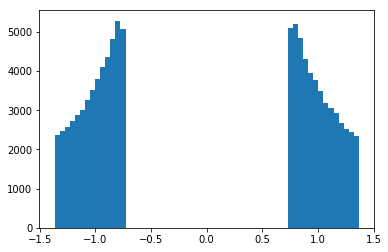

In [43]:
inter_sampler = random_sign(one_mean_prod_sample)
extra_sampler = one_mean_prod_sample

_ = plt.hist(inter_sampler(size=100000), bins=60)

In [5]:
n = 100
np.mean(np.prod(one_mean_prod_sample(size=(1000, n)), axis=1))

0.7816567084030749

In [44]:
train_loader = dataset.dataloader(batch_size=64, samplers=[inter_sampler])
dataset_valid_interpolation_data = next(iter(dataset.dataloader(batch_size=10000, samplers=[inter_sampler])))
dataset_test_extrapolation_data = next(iter(dataset.dataloader(batch_size=10000, samplers=[extra_sampler])))

model = LeibnizModule(n+2, 100).cuda()
train_until_convergence(
    model,
    train_loader,
    dataset_valid_interpolation_data,
    dataset_test_extrapolation_data,
    regualizer_scaling_start=5000,
    verbose=True,
    lr=1e-4
)

[epoch 250] inter: 0.9853, extra: 2.493
[epoch 500] inter: 0.9836, extra: 2.481
[epoch 750] inter: 0.9814, extra: 2.05
[epoch 1000] inter: 0.978, extra: 1.498
[epoch 1250] inter: 0.9727, extra: 1.517
[epoch 1500] inter: 0.9618, extra: 1.632
[epoch 1750] inter: 0.938, extra: 1.026
[epoch 2000] inter: 0.8883, extra: 0.7666
[epoch 2250] inter: 0.7864, extra: 0.6987
[epoch 2500] inter: 0.6118, extra: 0.4813
[epoch 2750] inter: 0.4028, extra: 0.2995
[epoch 3000] inter: 0.2335, extra: 0.2267
[epoch 3250] inter: 0.1205, extra: 0.3184
[epoch 3500] inter: 0.06383, extra: 0.527
[epoch 3750] inter: 0.0365, extra: 0.5729
[epoch 4000] inter: 0.02493, extra: 0.3784
[epoch 4250] inter: 0.01903, extra: 0.2452
[epoch 4500] inter: 0.0153, extra: 0.2496
[epoch 4750] inter: 0.01266, extra: 0.1942
[epoch 5000] inter: 0.01044, extra: 0.1048 | reg: 0.06471 (scale: 0.01)
[epoch 5250] inter: 0.00865, extra: 0.05745 | reg: 0.0646 (scale: 0.01284)
[epoch 5500] inter: 0.007165, extra: 0.04707 | reg: 0.0645 (scale

True

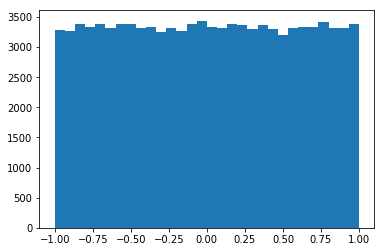

In [46]:
inter_sampler = uniform(-1, 1)
extra_sampler = one_mean_prod_sample

_ = plt.hist(inter_sampler(size=100000), bins=30)

In [48]:
train_loader = dataset.dataloader(batch_size=64, samplers=[inter_sampler])
dataset_valid_interpolation_data = next(iter(dataset.dataloader(batch_size=10000, samplers=[inter_sampler])))
dataset_test_extrapolation_data = next(iter(dataset.dataloader(batch_size=10000, samplers=[extra_sampler])))

model = LeibnizModule(n+2, 100).cuda()
train_until_convergence(
    model,
    train_loader,
    dataset_valid_interpolation_data,
    dataset_test_extrapolation_data,
    regualizer_scaling_start=10000,
    max_iter=25000,
    check_period=500,
    verbose=True,
    lr=1e-4
)

[epoch 500] inter: 1.205, extra: 2.447
[epoch 1000] inter: 1.193, extra: 2.913
[epoch 1500] inter: 1.187, extra: 2.172
[epoch 2000] inter: 1.184, extra: 1.943
[epoch 2500] inter: 1.181, extra: 1.923
[epoch 3000] inter: 1.18, extra: 1.795
[epoch 3500] inter: 1.179, extra: 1.757
[epoch 4000] inter: 1.178, extra: 1.078
[epoch 4500] inter: 1.175, extra: 1.196
[epoch 5000] inter: 1.175, extra: 1.191
[epoch 5500] inter: 1.173, extra: 1.25
[epoch 6000] inter: 1.173, extra: 1.266
[epoch 6500] inter: 1.173, extra: 1.208
[epoch 7000] inter: 1.172, extra: 1.133
[epoch 7500] inter: 1.171, extra: 1.249
[epoch 8000] inter: 1.17, extra: 1.215
[epoch 8500] inter: 1.171, extra: 1.073
[epoch 9000] inter: 1.171, extra: 1.025
[epoch 9500] inter: 1.171, extra: 1.158
[epoch 10000] inter: 1.17, extra: 1.137 | reg: 0.06642 (scale: 0.01)
[epoch 10500] inter: 1.17, extra: 1.007 | reg: 0.06641 (scale: 0.01648)
[epoch 11000] inter: 1.169, extra: 1.092 | reg: 0.06639 (scale: 0.02717)
[epoch 11500] inter: 1.17, ext

False